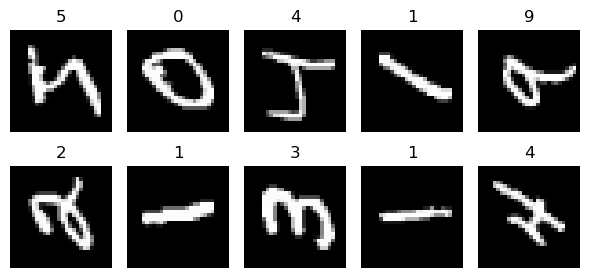

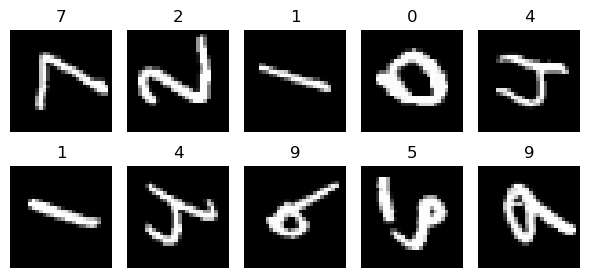

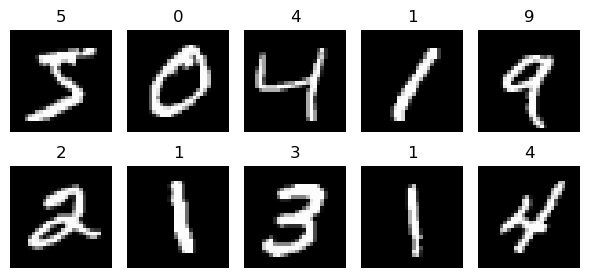

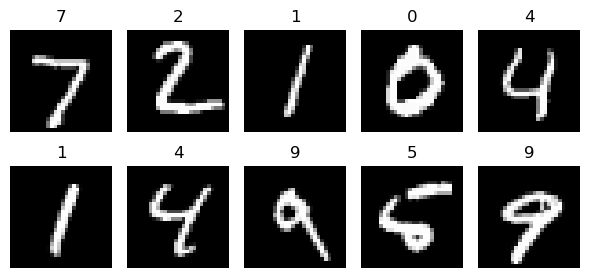

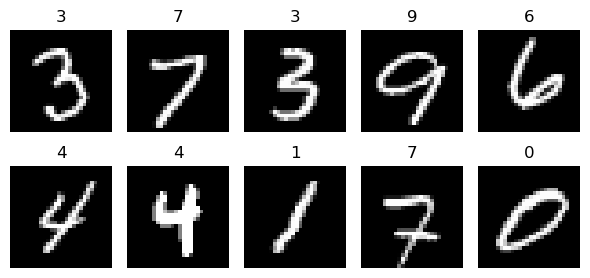

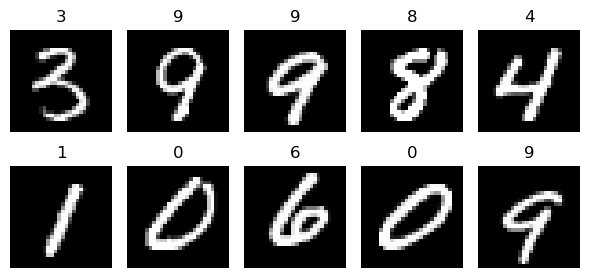

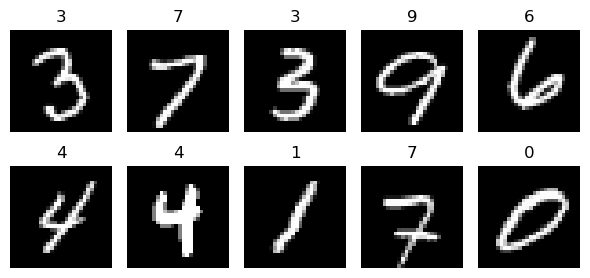

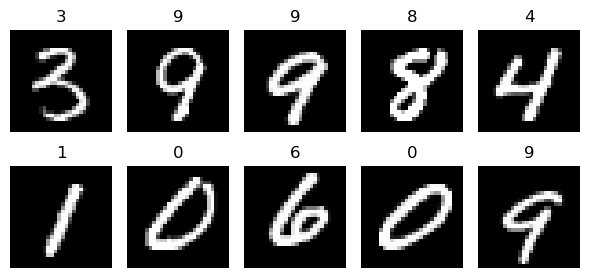

In [15]:
import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import random
import torch
from torch.utils.data import random_split, DataLoader
import numpy as np


import copy
import torch
from torchvision import datasets, transforms
from sampling import mnist_iid, mnist_noniid, mnist_noniid_unequal, mnist_noniid_mix
from sampling import cifar_iid, cifar_noniid
from torch import nn
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.nn.utils.parametrize as parametrize
from models import WeightAverageParametrization
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset

from matplotlib import pyplot as plt


# fix all random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# define paths
path_project = os.path.abspath('..')
data_dir = '../data/mnist/'
transformed_data_dir = '../data/mnist_transformed/'


# load the mnist dataset from the data directory without shuffling, rotate the first half 
# of the training images and testing images by 90 degrees and save the transformed dataset 
# to the transformed_data_dir
mnist_full = datasets.MNIST(data_dir, train=True, download=True)
mnist_test = datasets.MNIST(data_dir, train=False, download=True)
original_mnist_full = copy.deepcopy(mnist_full)
original_mnist_test = copy.deepcopy(mnist_test)
original_mnist_full.transform = transforms.Compose([
    transforms.ToTensor()
])
original_mnist_test.transform = transforms.Compose([
    transforms.ToTensor()
])


# split the training set into two halves sequentially
mnist_train_rotate = torch.utils.data.Subset(mnist_full, range(30000))
mnist_train = torch.utils.data.Subset(mnist_full, range(30000, 60000))
mnist_train_unchanged = copy.deepcopy(mnist_train)


def rotate_90(image):
    return TF.rotate(image, 90)

# rotate the first half of the training images by 90 degrees
mnist_train_rotate.dataset.transform = transforms.Compose([
    rotate_90,
])


# split the testing set into two halves
mnist_test_rotate = torch.utils.data.Subset(mnist_test, range(5000))
mnist_test = torch.utils.data.Subset(mnist_test, range(5000, 10000))
mnist_test_unchanged = copy.deepcopy(mnist_test)

# rotate the first half of the testing images by 90 degrees
mnist_test_rotate.dataset.transform = transforms.Compose([
    rotate_90,
])


mnist_train_combined = torch.utils.data.ConcatDataset([mnist_train_rotate, mnist_train_unchanged])
mnist_test_combined = torch.utils.data.ConcatDataset([mnist_test_rotate, mnist_test_unchanged])

# save the combined datasets to the transformed_data_dir directory
torch.save(mnist_train_combined, transformed_data_dir + 'mnist_train_combined.pt')
torch.save(mnist_test_combined, transformed_data_dir + 'mnist_test_combined.pt')

# load the transformed datasets from the transformed_data_dir
mnist_train_combined = torch.load(transformed_data_dir + 'mnist_train_combined.pt')
mnist_test_combined = torch.load(transformed_data_dir + 'mnist_test_combined.pt')

class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)


# apply transform on the loaded datasets
apply_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

mnist_train_combined = TransformDataset(mnist_train_combined, apply_transform)
mnist_test_combined = TransformDataset(mnist_test_combined, apply_transform)



# plot the first 10 images in the combined training set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(mnist_train_combined[i][0].squeeze(), cmap='gray')
    ax[i//5][i%5].set_title(mnist_train_combined[i][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images in the combined testing set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(mnist_test_combined[i][0].squeeze(), cmap='gray')
    ax[i//5][i%5].set_title(mnist_test_combined[i][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images in the original training set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(original_mnist_full[i][0].squeeze(), cmap='gray')
    ax[i//5][i%5].set_title(original_mnist_full[i][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images in the original testing set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(original_mnist_test[i][0].squeeze(), cmap='gray')
    ax[i//5][i%5].set_title(original_mnist_test[i][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()


# plot the first 10 images starting from the second half in the combined training set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(mnist_train_combined[i+30000][0].squeeze(), cmap='gray')
    ax[i//5][i%5].set_title(mnist_train_combined[i+30000][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images starting from the second half in the combined testing set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(mnist_test_combined[i+5000][0].squeeze(), cmap='gray')
    ax[i//5][i%5].set_title(mnist_test_combined[i+5000][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images starting from the second half in the original training set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(original_mnist_full[i+30000][0].squeeze(), cmap='gray')
    ax[i//5][i%5].set_title(original_mnist_full[i+30000][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images starting from the second half in the original testing set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(original_mnist_test[i+5000][0].squeeze(), cmap='gray')
    ax[i//5][i%5].set_title(original_mnist_test[i+5000][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()



Files already downloaded and verified
Files already downloaded and verified


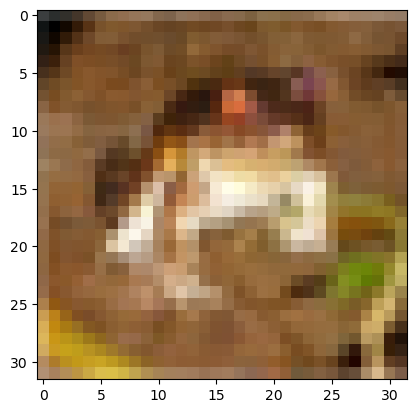

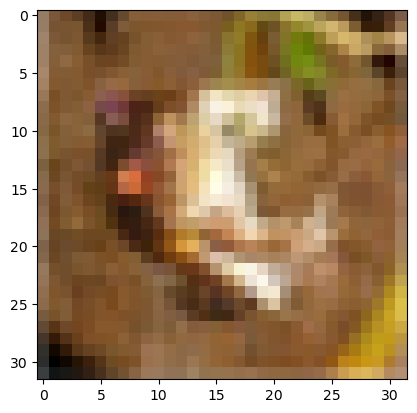

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

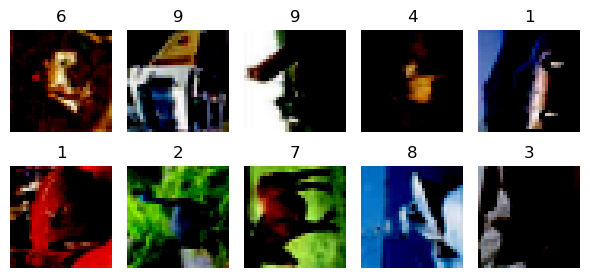

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

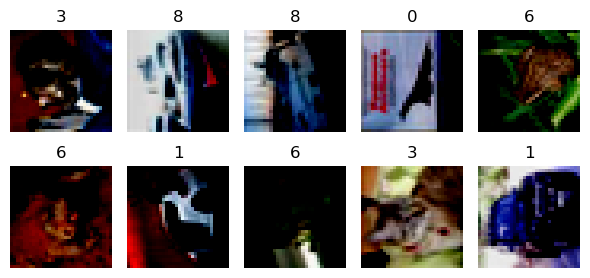

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

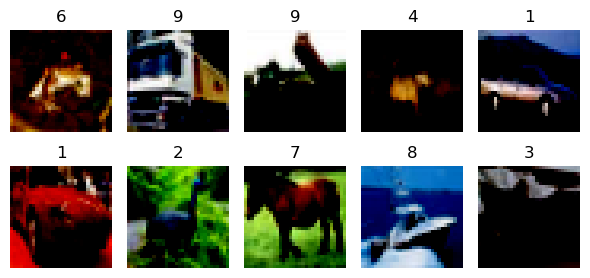

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

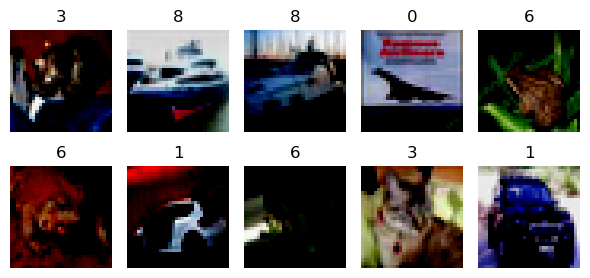

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

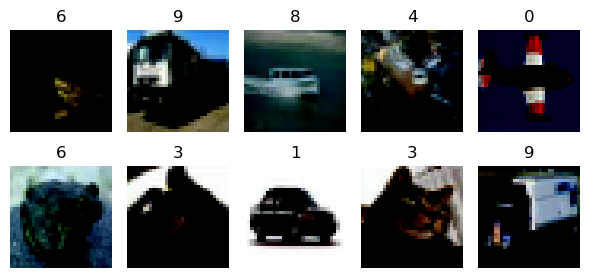

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

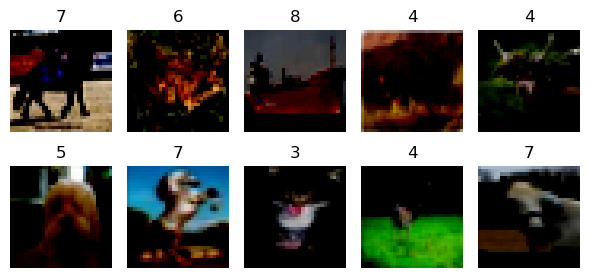

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

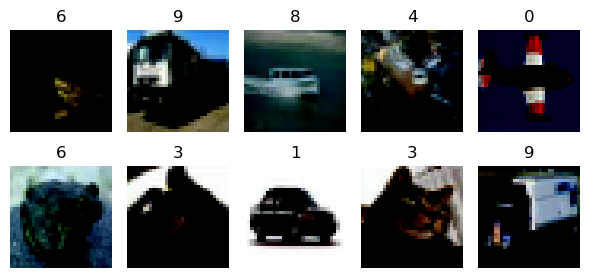

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

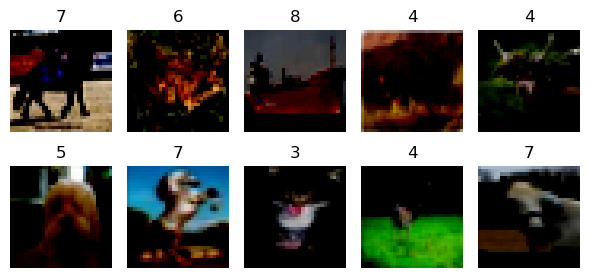

In [42]:
import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import random
import torch
from torch.utils.data import random_split, DataLoader
import numpy as np
from PIL import Image


import copy
import torch
from torchvision import datasets, transforms
from sampling import mnist_iid, mnist_noniid, mnist_noniid_unequal, mnist_noniid_mix
from sampling import cifar_iid, cifar_noniid
from torch import nn
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.nn.utils.parametrize as parametrize
from models import WeightAverageParametrization
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset

from matplotlib import pyplot as plt


# fix all random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# define paths
path_project = os.path.abspath('..')
data_dir = '../data/cifar/'
transformed_data_dir = '../data/cifar_transformed/'

# load the cifar10 dataset from the data directory without shuffling, add a random noise to the first half
# of the training images and testing images and save the transformed dataset to the transformed_data_dir

cifar_full = datasets.CIFAR10(data_dir, train=True, download=True)
cifar_test = datasets.CIFAR10(data_dir, train=False, download=True)
original_cifar_full = copy.deepcopy(cifar_full)
original_cifar_test = copy.deepcopy(cifar_test)
original_cifar_full.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
original_cifar_test.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# split the training set into two halves sequentially
cifar_train_noise = torch.utils.data.Subset(cifar_full, range(25000))
cifar_train = torch.utils.data.Subset(cifar_full, range(25000, 50000))
cifar_train_unchanged = copy.deepcopy(cifar_train)

plt.imshow(cifar_train_noise[0][0])
plt.show()

def rotate_90(image):
    return TF.rotate(image, 90)

# Define a function to add gaussian noise to a PIL image
def gaussian_noise(x, mean=0, std=50):
    # Convert PIL image to numpy array
    x = np.array(x)
    # Add gaussian noise
    x = x + np.random.normal(mean, std, x.shape)
    # Clip the values to be between 0 and 255
    x = np.clip(x, 0, 255)
    # Convert numpy array back to PIL image
    x = Image.fromarray(x.astype(np.uint8))
    return x


cifar_train_noise.dataset.transform = transforms.Compose([
    # transforms.ToTensor(),
    # add_noise,
    rotate_90,
])

plt.imshow(cifar_train_noise[0][0])
plt.show()


# split the testing set into two halves
cifar_test_noise = torch.utils.data.Subset(cifar_test, range(5000))
cifar_test = torch.utils.data.Subset(cifar_test, range(5000, 10000))
cifar_test_unchanged = copy.deepcopy(cifar_test)

# add gaussian noise to the first half of the testing images
cifar_test_noise.dataset.transform = transforms.Compose([
    # transforms.ToTensor(),
    # add_noise,
    rotate_90,
])


cifar_train_combined = torch.utils.data.ConcatDataset([cifar_train_noise, cifar_train_unchanged])
cifar_test_combined = torch.utils.data.ConcatDataset([cifar_test_noise, cifar_test_unchanged])





# save the combined datasets to the transformed_data_dir directory
torch.save(cifar_train_combined, transformed_data_dir + 'cifar_train_combined.pt')
torch.save(cifar_test_combined, transformed_data_dir + 'cifar_test_combined.pt')

# load the transformed datasets from the transformed_data_dir
cifar_train_combined = torch.load(transformed_data_dir + 'cifar_train_combined.pt')
cifar_test_combined = torch.load(transformed_data_dir + 'cifar_test_combined.pt')


class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)
    
# apply transform on the loaded datasets
apply_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

cifar_train_combined = TransformDataset(cifar_train_combined, apply_transform)
cifar_test_combined = TransformDataset(cifar_test_combined, apply_transform)



# plot the first 10 images in the combined training set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(cifar_train_combined[i][0].permute(1, 2, 0))
    ax[i//5][i%5].set_title(cifar_train_combined[i][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images in the combined testing set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(cifar_test_combined[i][0].permute(1, 2, 0))
    ax[i//5][i%5].set_title(cifar_test_combined[i][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images in the original training set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(original_cifar_full[i][0].permute(1, 2, 0))
    ax[i//5][i%5].set_title(original_cifar_full[i][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images in the original testing set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(original_cifar_test[i][0].permute(1, 2, 0))
    ax[i//5][i%5].set_title(original_cifar_test[i][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images starting from the second half in the combined training set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(cifar_train_combined[i+25000][0].permute(1, 2, 0))
    ax[i//5][i%5].set_title(cifar_train_combined[i+25000][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images starting from the second half in the combined testing set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(cifar_test_combined[i+5000][0].permute(1, 2, 0))
    ax[i//5][i%5].set_title(cifar_test_combined[i+5000][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images starting from the second half in the original training set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(original_cifar_full[i+25000][0].permute(1, 2, 0))
    ax[i//5][i%5].set_title(original_cifar_full[i+25000][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# plot the first 10 images starting from the second half in the original testing set with labels
fig, ax = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    ax[i//5][i%5].imshow(original_cifar_test[i+5000][0].permute(1, 2, 0))
    ax[i//5][i%5].set_title(original_cifar_test[i+5000][1])
    ax[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()
